코랩 세션 유지
```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

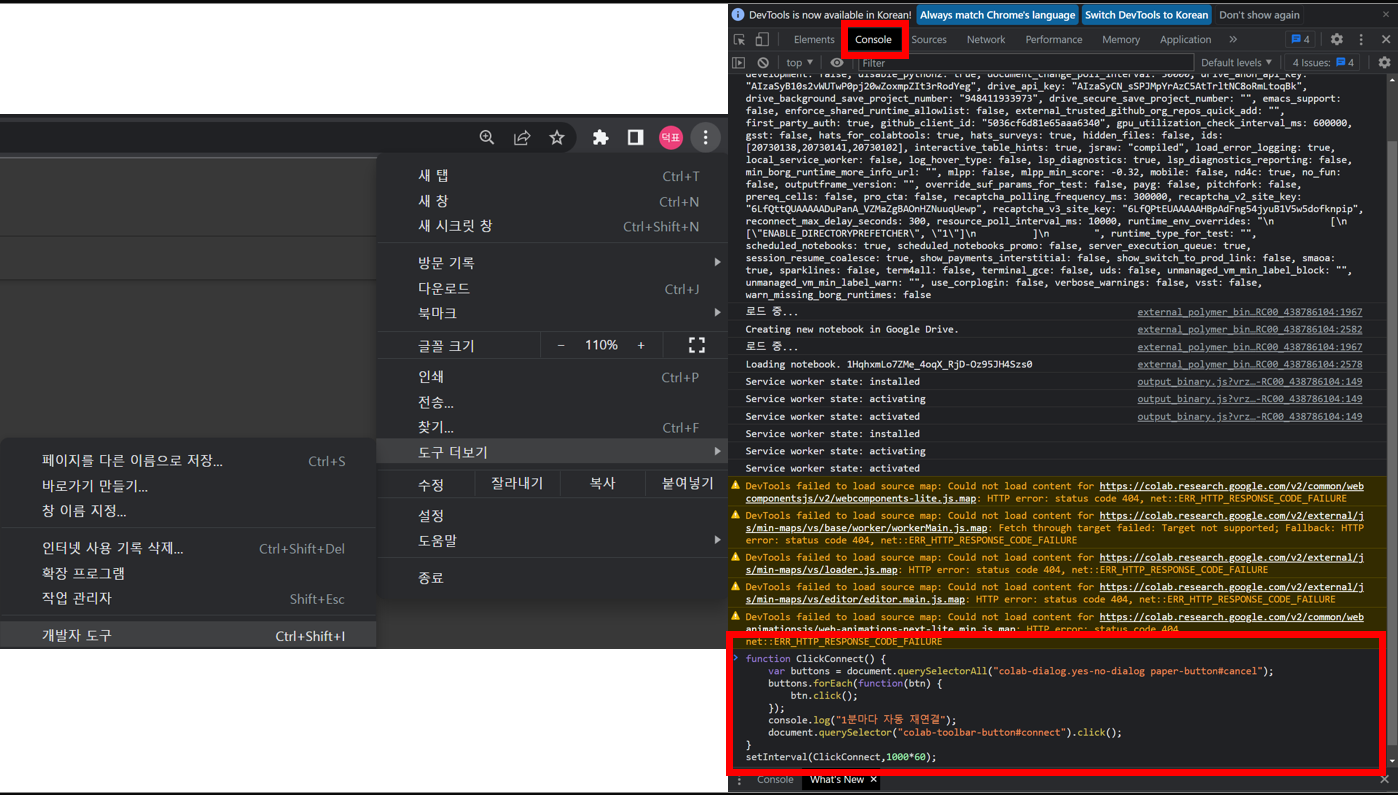

# 비지도 학습

## [생성적 적대 신경망(GAN: Generative Adversarial Networks)](https://arxiv.org/pdf/1406.2661)
- GAN은 데이터를 만들어내는 Generator와 만들어진 데이터의 진위여부를 평가하는 Discriminator가 서로 대립적으로 학습해가며 성능을 점차 개선해 나아가는 방법으로 예측의 목적을 뛰어넘어 생성을 목적으로 한다.

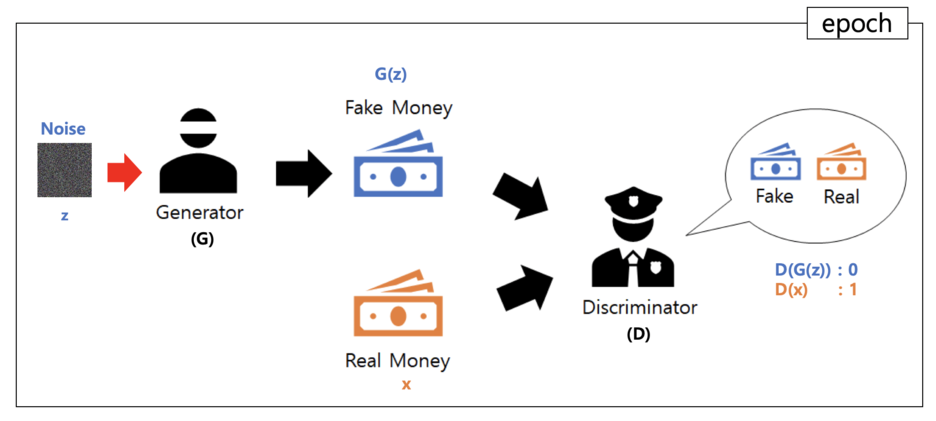

[생성적 적대 신경망](https://arxiv.org/pdf/1406.2661) 논문에서 Generator와 Discriminator를 지폐위조범과 경찰로 비유. 지폐위도범은 경찰을 속이기 위해 학습하고 경찰은 위조된 지폐를 감별하기위해 학습한다. 이러한 일련의 경쟁 끝어 경찰과 위조지폐범은 구별하고 속이는 서로의 능력이 발전하고 결과적으로 진짜 지폐와 위조 지폐를 구별할 수 없을 정도(구별할 확률 = 0.5)에 이른다.         
      
------------------------------------

GAN은 다음과 같은 함수에서 Minimax Problem을 풀게 된다.   
Generator $G$에서는 Minimize하려 노력하고, Discriminator $D$의 입장에서 Maximize하려 노력하게 된다. 해당 논문에서 $G$와 $D$의 입장에서 각각 자신의 역할을 수행할 때 진짜분포와 가짜분포가 같아진다는 것을 이론적으로 증명함.


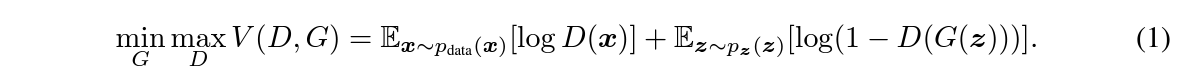

- $D$의 입장에서 $D(x)$가 1이고(진짜 데이터를 1로 구분) $D(G(z))$가 0일때(가짜 데이터를 0으로 구분) $V$는 최대 값을 갖는다.
- 반대로 $G$입장에서 $D(G(z))$가 1일때(가짜 데이터를 1로 속임) V는 최소 값을 갖는다.

```
1. 제일 처음 0과 1로 인해 마구 뿌려진(아무리 봐도 티비 제대로 안 나올 때 지지직거리는 화면이다)   
Noise라는 쓰레기가 있다. 해당 Noise는 위 수식에서 z라고 표현.
​
2. 해당 쓰레기를 가지고 Generator(위조지폐범이) 위조지폐를 만든다. 
G가 z를 가지고 만들었으니 만들어진 위조지폐들을 위 수식에서 G(z)라고 함.

3. 이제 Discriminator(경찰) 이 위조지폐와 실제 지폐를 구분해야 한다. 
경찰은 이게 위조지폐라면 0을 출력하고, 진짜 지폐라면 1을 출력하기로 한다. 
위조지폐 G(z) 와 실제 지폐 x 가 경찰 손으로 들어갔을 때, D(G(z))는 위조지폐이기 때문에 0, 실제 지폐는 D(x)는 1을 출력하게 된다. 
```

- Discriminator 모델은 Supervised Learning이며, Generator 모델은 Unsupervised Learning 모델이다.


### Discriminator의 학습 과정
- Discriminator는 진짜 데이터를 진짜로, 가짜 데이터를 가짜로 분류하는 것이 목적.
- 때문에 input데이터롤 가짜/진짜 데이터가 모두 필요.
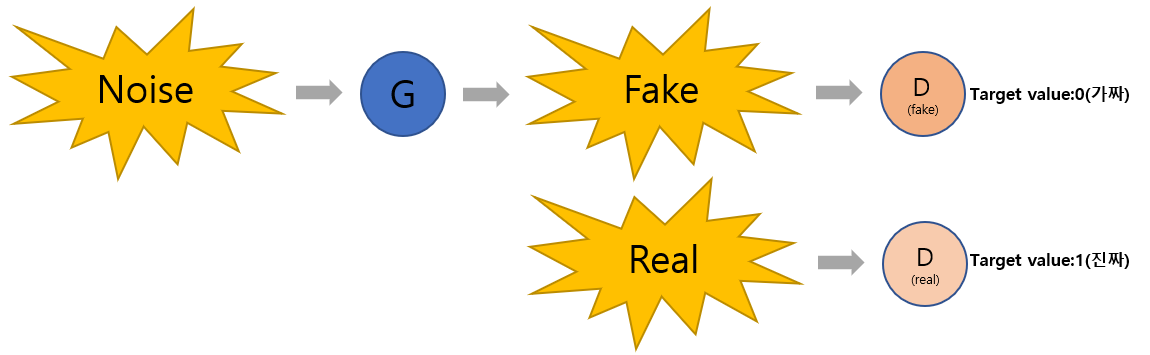

### Generator의 학습과정
- Generator의 목적은 데이터를 '생성'해 내는 것이기 때문에 이를 기점으로 모델을 학습.
- Generator $G$를 잘 학습 시키기 위해 Discriminator $D$를 잘 속여야 한다. 먼저 Noise로 부터 $G$를 통해 가짜 데이터를 만든다.
- $G$를 통해 만들어진 가짜 데이터를 만들고 이를 $D$에 input로 넣는데 까지 Feed forward의 과정.
    - 일반적인 뉴럴 네트워크의 Feed forward와 다름.(일반적인 뉴럴 네트워크는 '입력->히든레이어->출력')
    - Generator는 Generator의 output을 Discriminator의 input로 넣어 output까지 계산.($G$의 목적이 $D$를 속이는 것이고, D의 오차를 통해 $G$의 역전파를 계산하기 때문.
- $G$는 $D$를 속이는 방향으로 $G$의 가중치를 업데이트
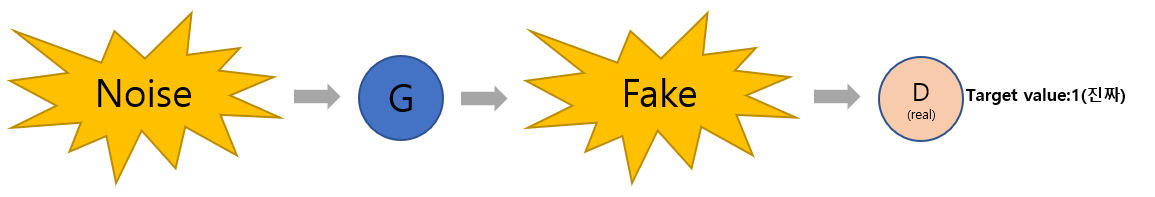

### Generator의 가중치 업데이트

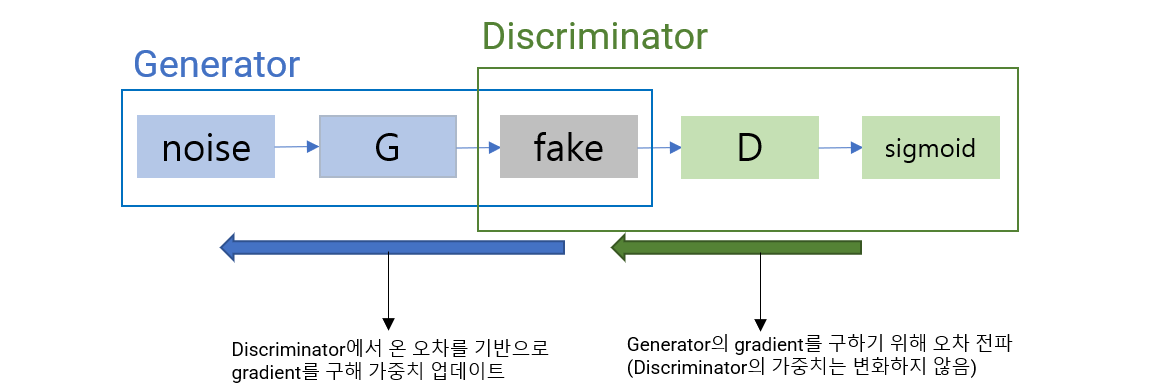
- GAN은 $D$와 $G$가 번갈아 가면서 학습을 진행. 이 과정을 무수히 반복하면 진짜와 가짜를 구별할 확률이 0.5가 된다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
# Generator 생성
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features = 128
        self.n_out = 784 # 784(28x28) 크기 벡터를 출력으로 사용
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh()
            )
        ''' ReLU는 입력값이 음수이면 0으로 값을 변환,
            따라서 음수 구간에서 미분을 할 경우 0이 반환된다.
            이때 기울기 사라짐 방지를 위해 음수 구간의 양의 
            기울기를 주어 값을 계산하는 nn.LeakyReLU(0.2)로
            대체하여 사용. 0.2는 음수 구간의 그래프가 y=0.2x라는 의미로
            직선의 기울기를 나타낸다.
        '''
    def forward(self, x): # 여기서 x는 노이즈
        x = self.linear(x)
        x = x.view(-1, 1,28,28)
        return x

In [9]:
# 분류자 모델 층 생성
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid() # 진위여부인 0/1 사이의 값이 출력되도록 시그모이드 함수 적용.
        )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## pretrained =  True로 주면 전이학습이 가능
# pretrained =  False
# if pretrained == True:
#     discriminator.load_state_dict(torch.load('./fmnist_disc.pth'))
#     generator.load_state_dict(torch.load('./fmnist_gner.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

def noise(n, n_features = 128):
    data = torch.randn(n, n_features)
    return data.to(device)

# GAN은 판별자가 학습하는 것은 이미지의 진위 여부에 대한 계산을 한다.
# 실제로 MNIST에서는 이미지에 대한 라벨이 0~9까지 있다.
# MNIST의 진짜 이미지의 라벨은 모두 1으로
# 생성자에서 나온 가짜이미지의 라벨은 0으로 해주어야
# 판별자가 학습하면서 가중치를 업데이트할 수 있다.

def label_zeros(size):
    data = torch.zeros(size,1)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size,1)
    return data.to(device)

In [17]:
criterion = nn.BCELoss() # 이진크로스엔트로피 사용

In [18]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0) # 각 이미지의 라벨링을 위해 갯수 확인
    optimizer.zero_grad()

    prediction_real = discriminator(real_data) # 진짜 이미지를 학습
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data) # 진짜 이미지를 학습
    g_loss = criterion(prediction_fake, label_zeros(n))

    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()

    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    # G입장에선 D가 진짜 이미지라고 판독해야 하기 때문에 라벨링을 1로 넣어 손실 함수를 계산
    # 이런 방식으로 min max 손실함수를 정의하지 않고 최적화 수행 가능
    loss.backward()
    optimizer.step()

    return loss.item()

In [22]:
test_noise = noise(64)
l = len(trainloader)

for epoch in tqdm(range(200)):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)

        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: g_loss: {g_loss/l:.3f} d_loss: {d_loss/1:.3f}')

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: g_loss: 3.490 d_loss: 365.761
Epoch 10: g_loss: 1.898 d_loss: 468.882
Epoch 20: g_loss: 1.561 d_loss: 536.212
Epoch 30: g_loss: 1.357 d_loss: 585.611
Epoch 40: g_loss: 1.292 d_loss: 610.444
Epoch 50: g_loss: 1.247 d_loss: 624.746
Epoch 60: g_loss: 1.188 d_loss: 652.663
Epoch 70: g_loss: 1.119 d_loss: 673.584
Epoch 80: g_loss: 1.103 d_loss: 691.544
Epoch 90: g_loss: 1.074 d_loss: 701.774
Epoch 100: g_loss: 1.048 d_loss: 707.781
Epoch 110: g_loss: 1.062 d_loss: 703.382
Epoch 120: g_loss: 1.056 d_loss: 709.615
Epoch 130: g_loss: 1.006 d_loss: 730.233
Epoch 140: g_loss: 0.990 d_loss: 727.543
Epoch 150: g_loss: 1.038 d_loss: 726.121
Epoch 160: g_loss: 0.985 d_loss: 726.213
Epoch 170: g_loss: 1.014 d_loss: 722.651
Epoch 180: g_loss: 0.982 d_loss: 735.757
Epoch 190: g_loss: 0.991 d_loss: 736.715


In [20]:
torch.save(discriminator.state_dict(), './fmnist_disc.pth') 
torch.save(generator.state_dict(), './fmnist_gner.pth')    

In [23]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items_gan.gif', imgs)

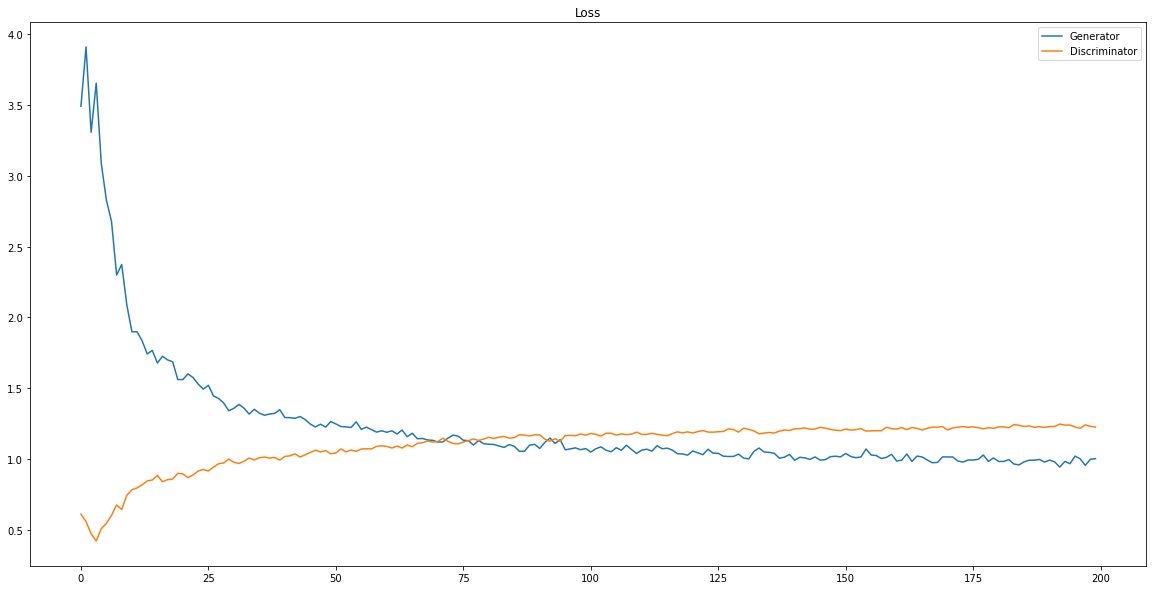

In [24]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

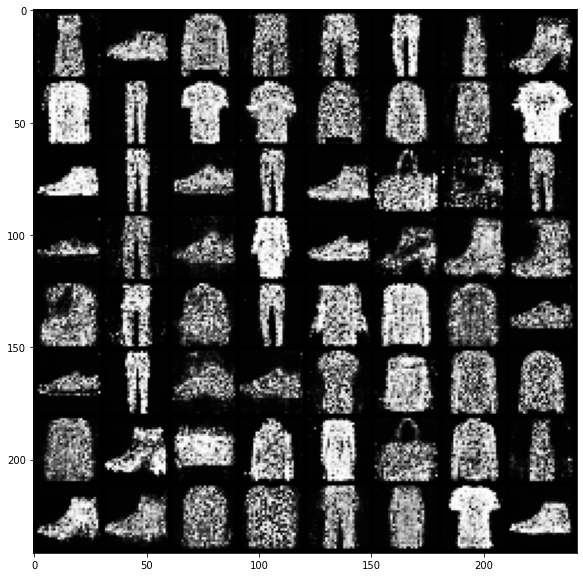

In [25]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### 추가 추천글
- https://post.naver.com/viewer/postView.nhn?volumeNo=16425037&memberNo=36733075
- https://m.post.naver.com/viewer/postView.nhn?volumeNo=16566740
- https://post.naver.com/viewer/postView.nhn?volumeNo=16706734&memberNo=36733075